# 01 module

In [ ]:
import scanpy as sc
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from matplotlib import colors, rcParams
import h5py
import logging

In [ ]:
from scipy.stats import median_abs_deviation

In [ ]:
import rpy2.rinterface_lib.callbacks
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
%load_ext rpy2.ipython

In [ ]:
%%R
.libPaths(c("/public/home/liuzj/softwares/anaconda3/envs/R/lib/R/library/","/public/home/qinyw/R/x86_64-conda-linux-gnu-library/4.1"))
.libPaths()

[1] "/public1/software/liuzj/softwares/anaconda3/envs/R/lib/R/library"
[2] "/public/home/qinyw/R/x86_64-conda-linux-gnu-library/4.1"         
[3] "/public/home/qinyw/software/miniconda3/envs/sc_r/lib/R/library"  


In [ ]:
from jpy_tools import rTools
from jpy_tools import singleCellTools

<Figure size 72x72 with 0 Axes>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp

In [ ]:
from matplotlib.pyplot import rc_context

In [ ]:
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import marsilea as ma
import marsilea.plotter as mp

In [ ]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import marsilea as ma
import marsilea.plotter as mp
# plt.rcParams['figure.dpi'] = 150
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
sns.despine(top=True, right=True)
from itertools import product
from functools import reduce
import patchworklib as pw
from jpy_tools.otherTools import pwRecoverSeaborn, pwStack, F, pwShow
pw.show = pwShow
fc_recoverSns = pwRecoverSeaborn()
import seaborn.objects as so
from cycler import cycler
dt_snsStyle = {**sns.axes_style('ticks'), "legend.frameon": False, "axes.spines.top":False, "axes.spines.right":False, "axes.prop_cycle":cycler(color=['grey'])}
so.Plot.config.theme.update(dt_snsStyle)
from jpy_tools.soExt import Axhline, Axvline, mvLegToAx
plt.set_loglevel('Warning')

ModuleNotFoundError: No module named 'patchworklib'

<Figure size 432x288 with 0 Axes>

In [ ]:
sc.set_figure_params(dpi =300)

# 02.data

In [ ]:
bdata = sc.read_h5ad('/data/Zhaijx/qinyw/data/flsnRNA/illumina_lib/circadian/revision/03_h5ad/48hourAnndata.h5ad')

In [ ]:
bdata

AnnData object with n_obs × n_vars = 77142 × 32833
    obs: 'CT', 'Source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_organelle', 'log1p_total_counts_organelle', 'pct_counts_organelle', 'passFilter', 'temp', 'passQc', '__group', 'Cluster', 'CT_int', 'CT_raw', 'embedding_color_temp', 'Cluster_fine', 'Cluster_final', 'anno', 'temp_batch', 'temp_split', 'Cluster_revise'
    var: 'organelle', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: 'CT_colors', 'CT_raw_colors', 'Cluster_cellexES', 'Cluster_colors', 'Cluster_final_cellexES', 'Cluster_final_colors', 'Cluster_fine', 'Cluster_fine_cellexES', 'Cluster_fine_colors', 'EnhancedAnndata_rawLayer', 'anno_colors', 'dendrogram_Cluster', 'dendrogram_Cluster_final', 'dendrogram_Cluster_fine', 'labelTransfer_pseudoSeedling', 'log1p', 'metacycle_normalizeLog_0729', 'metacycle_normalizeLog_0814'

# 03 spatialtemporal validation 

In [ ]:
rep1 = pd.read_excel('./LUC_data_shiqi_20231113.xlsx',sheet_name='#1')
rep2 = pd.read_excel('./LUC_data_shiqi_20231113.xlsx',sheet_name='#2')

In [ ]:
def dataClean(df, scale = True):
    df_clean = df.dropna(axis = 1, how = 'all')
    df_clean.columns = [x if (not 'Unnamed' in x) else np.nan for x in df_clean.columns]
    df_clean.columns = pd.Series(df_clean.columns).fillna(method='ffill')
    df_plot = df_clean.loc[(df_clean['Time'] > 24) & (df_clean['Time'] < 48)].set_index('Time').stack().reset_index().rename(columns = {'level_1':'gene',0:'value'}).groupby(['gene','Time']).agg('mean').reset_index()
    df_plot['std'] = df_clean.loc[(df_clean['Time'] > 24) & (df_clean['Time'] < 48)].set_index('Time').stack().reset_index().rename(columns = {'level_1':'gene',0:'value'}).groupby(['gene','Time']).agg('std').reset_index()['value']
    if scale:
        df_scale = df_plot.copy()
        df_scale['value'] = ((df_scale['value'] - df_scale['value'].min()) / (df_scale['value'].max() - df_scale['value'].min()))
        df_plot['scale_value'] = df_scale['value'].copy()
    return df_plot
    

In [ ]:
df_clean1 = dataClean(rep1)
df_clean2 = dataClean(rep2)
df_bm3 = pd.read_excel('./gaoya_bm3_data.xlsx',sheet_name ='Sheet1')

In [ ]:
df_clean1['scale_value'] = df_clean1.groupby('gene')['value'].transform(lambda x: (x - x.mean()) / x.std())
df_clean2['scale_value'] = df_clean2.groupby('gene')['value'].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
ls_gene = adata.var_names.tolist()
df = sc.get.obs_df(adata,keys =[*ls_gene],layer = 'raw')
df2_cpm = df.copy()
df2_cpm['total'] = df2_cpm.sum(axis = 1)
df2_cpm = df.div(df2_cpm['total'],axis = 0)* 10**6
df2_plot = df2_cpm.loc[:,['AT1G08810','AT5G43520','AT5G47450','AT2G33790','AT1G66100','AT1G68530','AT1G06830','AT5G38420','AT1G29920','AT5G42650']]
df2_plot.columns =['BM19','BM6','BM4','BM5','BM3','BM12','BM20','BM15','BM16','MC1']

In [ ]:
df_bm3_plot = df_bm3.set_index('Time (h)').stack().reset_index().rename(columns = {'level_1':'gene',0:'value','Time (h)':'Time'})
df_bm3_plot = df_bm3_plot[df_bm3_plot['gene'].str.contains('BM3:LUC')]
bm3_plot = df_bm3_plot.groupby(['gene','Time']).agg('mean').reset_index()
bm3_plot['std'] = df_bm3_plot.groupby(['gene','Time']).agg('std').reset_index()['value']
bm3_plot = bm3_plot.loc[(bm3_plot['Time'] > 24) & (bm3_plot['Time'] < 49)]

In [ ]:
df_bm3.columns = [x.split('.')[0] for x in df_bm3.columns]

In [ ]:
def plot_geneInData(gene = None,scale = True):
    color = {'rep1':'#0C2C84','rep2':'#41B6C4','snRNA-seq':'#FC8D3D'}
    
    if scale:
        value = 'scale_value'
    else:
        value = 'value'
    
    
    fig, ax1 = plt.subplots(figsize = (6,4))
    x1 = df_clean1.loc[(df_clean1['gene'] == gene)]['Time']
    y1 = df_clean1.loc[(df_clean1['gene'] == gene)][value]
    x2 = df_clean2.loc[(df_clean2['gene'] == gene)]['Time']
    y2 = df_clean2.loc[(df_clean2['gene'] == gene)][value]
    x3 = df2_plot.reset_index()['index'].astype(float)
    y3 = df2_plot[gene]

    std1 = df_clean1.loc[(df_clean1['gene'] == gene)]['std']
    std2 = df_clean1.loc[(df_clean2['gene'] == gene)]['std'] 
    
    l1, = ax1.plot(x1,y1,marker ='o',color = color['rep1'])
    l2, = ax1.plot(x2,y2,marker ='o',color = color['rep2'])
    ax1.errorbar(x1,y1,yerr = std1,fmt = 'none',color = color['rep1'],capsize=3)
    ax1.errorbar(x2,y2,yerr = std1,fmt = 'none',color = color['rep2'],capsize=3)
    
    ax1.set_xlim(24,48)
    ax1.set_ylabel('Scaled LUC activity',fontsize = 12)
    ax1.set_xticks(range(24,48,2))

    ax2 = ax1.twinx()
    ax2.set_ylabel('CPM',fontsize = 12)
    l3, = ax2.plot(x3,y3,marker = 'o',color = color['snRNA-seq'])

    plt.title('$RBCS2B$'+'\n('+'$AT5G38420$'+')',fontsize = 12)
    ax1.set_xlabel('Time in continuous light (h)',fontsize = 12)
    #fig.legend((l1,l2,l3),('rep1','rep2','snRNA-seq'),loc = 'upper center',bbox_to_anchor = (.52,1.05),frameon = False,ncols = 3)
    plt.close()
    
    return fig

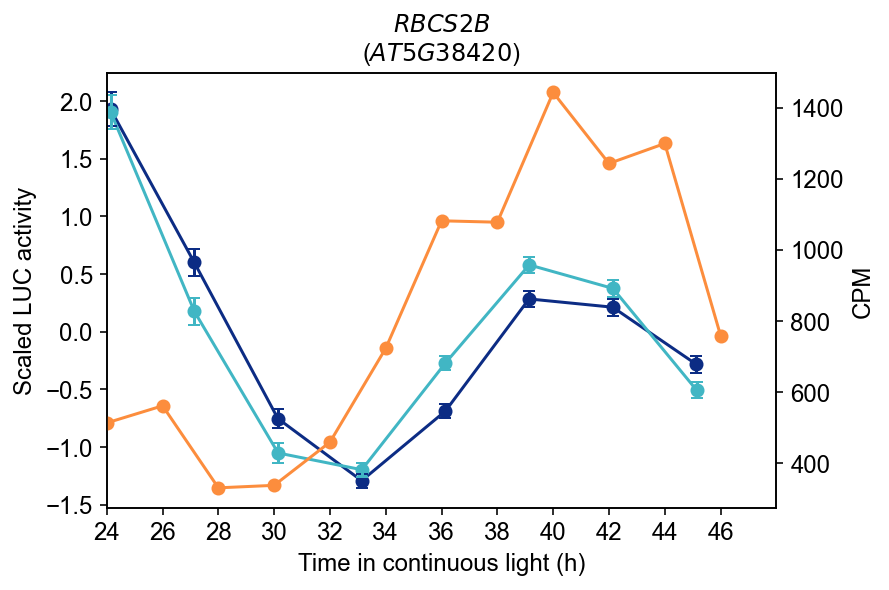

In [ ]:
plot_geneInData('BM15')

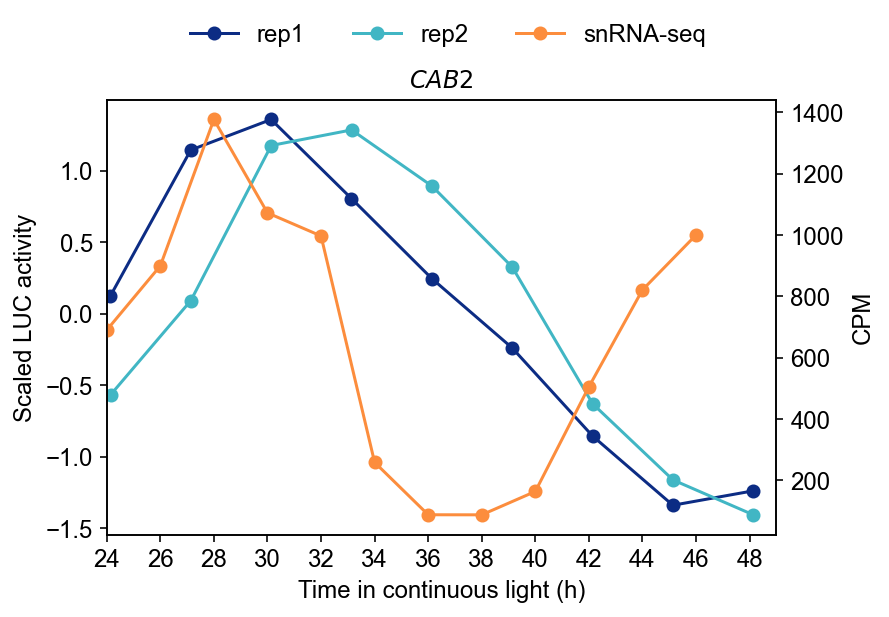

In [ ]:
plot_geneInData('BM16')

In [ ]:
df_bm3_plot['scale_value'] = df_bm3_plot.groupby('gene')['value'].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
def plot_geneInData(gene = None,scale = True):
    color = {'rep1':'#0C2C84','rep2':'#41B6C4','rep3':'#B2E0B6','CCA1':'#111111','snRNA-seq':'#FC8D3D'} 
    if scale:
        value = 'scale_value'
    else:
        value = 'value'
        
    fig, ax1 = plt.subplots(figsize = (6,4))
    # data of gaoya
    x1 = bm3_plot.loc[(bm3_plot['gene'] == gene+':LUC #1')]['Time']
    y1 = bm3_plot.loc[(bm3_plot['gene'] == gene+':LUC #1')][value]
    x2 = bm3_plot.loc[(bm3_plot['gene'] == gene+':LUC #2')]['Time']
    y2 = bm3_plot.loc[(bm3_plot['gene'] == gene+':LUC #2')][value]
    # std
    std1 = bm3_plot.loc[(bm3_plot['gene'] == gene+':LUC #1')]['std']
    std2 = bm3_plot.loc[(bm3_plot['gene'] == gene+':LUC #2')]['std']

    # snRNA-seq
    x4 = df2_plot.reset_index()['index'].astype(float)
    y4 = df2_plot[gene]


    l1, = ax1.plot(x1,y1,marker ='o',color = color['rep1'])
    l2, = ax1.plot(x2,y2,marker ='o',color = color['rep2'])
    #l3, = ax1.plot(x3,y3,marker ='o',color = color['rep3'])
    #l4, = ax1.plot(x_cca1,y_cca1,marker ='o',color = color['CCA1'])
    ax1.errorbar(x1,y1,yerr = std1,fmt = 'none', color = color['rep1'],capsize=3)
    ax1.errorbar(x2,y2,yerr = std1,fmt = 'none', color = color['rep2'],capsize=3)
    
    ax1.set_xlim(24,48)
    ax1.set_ylabel('Scaled LUC activity',fontsize = 12)
    ax1.set_xticks(range(24,48,2))

    ax2 = ax1.twinx()
    ax2.set_ylabel('CPM',fontsize = 12)
    l5, = ax2.plot(x4,y4,marker = 'o',color = color['snRNA-seq'])
    #l4, = ax2.plot(x_cca1,y_cca1,marker ='o',color = color['CCA1-snRNA-seq'])

    plt.title(f"${dt_gene[gene]}$",fontsize = 12)
    ax1.set_xlabel('Time in continuous light (h)',fontsize = 12)
    #fig.legend((l1,l2,l5),('BM3-rep1','BM3-rep2','BM3_snRNA-seq'),loc = 'upper right',bbox_to_anchor = (1.23,.88),frameon = False)
    plt.close() # 关闭plot
    
    return fig

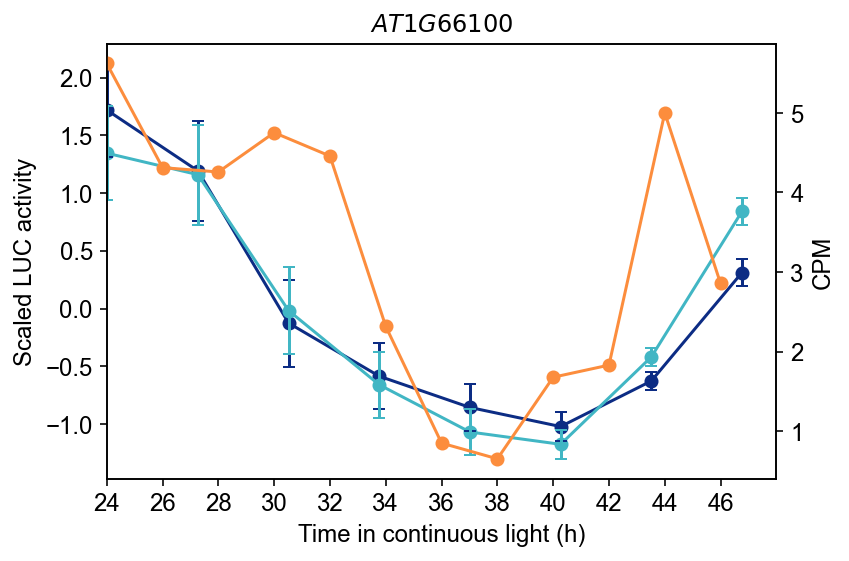

In [ ]:
plot_geneInData('BM3')

# 04 phase comparison

In [ ]:
adata = sc.read_h5ad('/data/Zhaijx/qinyw/data/flsnRNA/illumina_lib/circadian/revision/03_h5ad/48hourAnndata.h5ad')

In [ ]:
df_jtkCpmOrg = pd.read_table('../03_Analysis/00_jtkCpmOrg/48Hour.txt')

In [ ]:
df_gene = pd.read_table('../03_Analysis/02_CountCPM/48-hour_allGene.txt')
df_gene

,CycID,R0,R1,R2,R3,R4,R5,R6,R7,R8,...,V3,V4,U0,U1,U2,counts,CoreGene,CPM,regulator,ABF1
0,AT3G62550,10.0,10.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0,...,12.0,10.0,12.0,12.0,10.0,40,False,112.716829,False,False
1,AT3G26740,10.0,10.0,10.0,10.0,10.0,10.0,NaN,10.0,10.0,...,10.0,10.0,12.0,10.0,10.0,39,False,364.331529,False,False
2,AT2G05070,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,NaN,...,4.0,2.0,2.0,4.0,2.0,37,False,1202.301355,False,False
3,AT2G43010,6.0,6.0,6.0,6.0,NaN,6.0,NaN,6.0,4.0,...,6.0,6.0,4.0,6.0,6.0,37,False,36.369533,True,False
4,AT2G42530,10.0,12.0,12.0,12.0,10.0,12.0,NaN,10.0,NaN,...,10.0,12.0,12.0,12.0,10.0,37,False,90.334877,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9827,AT1G01040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,NaN,NaN,NaN,NaN,1,False,27.139000,False,False
9828,AT1G01020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,False,16.039821,False,False
9829,AT5G66820,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,False,6.914719,False,False
9830,AT5G66270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,False,2.484863,False,False


In [ ]:
df_jtkCpmOrg.merge(
    df_gene.iloc[:,:-5].melt('CycID',var_name = 'Cluster',value_name = 'phase').dropna(),
    on =['CycID','Cluster','phase'],
    how = 'inner').value_counts

,CycID,ARS_pvalue,ARS_BH.Q,ARS_period,ARS_adjphase,ARS_amplitude,JTK_pvalue,JTK_BH.Q,JTK_period,JTK_adjphase,...,meta2d_rAMP,Cluster,idxMax,phase,orgPhase,stdPhase,orgAmpli,stdAmpli,orgBase,stdBase
0,AT1G01650,0.022154,0.463848,24.0,8.952049,0.282126,0.001704,0.454435,24.0,10.0,...,0.057942,R0,R0,8,8.836904,1.066236,0.291260,0.081799,5.072276,0.057665
1,AT1G01770,0.003829,0.313745,24.0,9.523229,0.601493,0.003172,0.555030,24.0,10.0,...,0.181628,R0,R0,10,9.282317,0.788015,0.632981,0.129219,3.457433,0.091856
2,AT1G02340,0.002853,0.292908,24.0,7.692319,0.567584,0.005656,0.637560,24.0,8.0,...,0.137278,R0,R0,8,7.566437,0.647684,0.610294,0.108654,4.482262,0.075024
3,AT1G02730,0.305540,0.794967,24.0,6.865050,0.308074,0.040064,0.991179,24.0,6.0,...,0.163700,R0,R0,6,6.640111,1.718104,0.414722,0.199579,1.972184,0.136592
4,AT1G02810,0.008474,0.376589,24.0,5.286311,0.262687,0.040064,0.991179,24.0,6.0,...,0.044648,R0,R0,6,5.294659,0.868642,0.265760,0.064606,6.441807,0.044234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37249,AT5G63860,0.009722,0.940308,24.0,10.438300,0.837260,0.025736,1.000000,24.0,12.0,...,0.189076,U2,U2,10,9.944060,1.009348,0.894761,0.228557,4.501291,0.164424
37250,AT5G63890,0.022675,0.946510,24.0,4.626457,1.245195,0.000872,1.000000,24.0,6.0,...,0.389049,U2,U2,4,4.795781,0.902952,1.413163,0.353924,3.513410,0.243341
37251,AT5G64850,0.011808,0.946510,24.0,22.163503,0.197420,0.025736,1.000000,24.0,22.0,...,0.030446,U2,U2,22,21.445847,1.082108,0.223080,0.062162,6.671694,0.044323
37252,AT5G65920,0.047020,0.957732,24.0,11.480342,0.909114,0.040064,1.000000,24.0,12.0,...,0.283676,U2,U2,12,12.284779,1.640697,0.903223,0.361463,3.204624,0.265128


In [ ]:
df_jtkCpmOrg.columns

Index(['CycID', 'ARS_pvalue', 'ARS_BH.Q', 'ARS_period', 'ARS_adjphase',
       'ARS_amplitude', 'JTK_pvalue', 'JTK_BH.Q', 'JTK_period', 'JTK_adjphase',
       'JTK_amplitude', 'LS_pvalue', 'LS_BH.Q', 'LS_period', 'LS_adjphase',
       'LS_amplitude', 'meta2d_pvalue', 'meta2d_BH.Q', 'meta2d_period',
       'meta2d_phase', 'meta2d_Base', 'meta2d_AMP', 'meta2d_rAMP', 'Cluster',
       'idxMax', 'phase', 'orgPhase', 'stdPhase', 'orgAmpli', 'stdAmpli',
       'orgBase', 'stdBase'],
      dtype='object')

In [ ]:
df_filter = df_jtkCpmOrg.query('`JTK_pvalue` < 0.05')
df_filter

,CycID,ARS_pvalue,ARS_BH.Q,ARS_period,ARS_adjphase,ARS_amplitude,JTK_pvalue,JTK_BH.Q,JTK_period,JTK_adjphase,...,meta2d_rAMP,Cluster,idxMax,phase,orgPhase,stdPhase,orgAmpli,stdAmpli,orgBase,stdBase
32,AT1G01650,0.022154,0.463848,24.0,8.952049,0.282126,0.001704,0.454435,24.0,10.0,...,0.057942,R0,R0,8,8.836904,1.066236,0.291260,0.081799,5.072276,0.057665
36,AT1G01770,0.003829,0.313745,24.0,9.523229,0.601493,0.003172,0.555030,24.0,10.0,...,0.181628,R0,R0,10,9.282317,0.788015,0.632981,0.129219,3.457433,0.091856
62,AT1G02340,0.002853,0.292908,24.0,7.692319,0.567584,0.005656,0.637560,24.0,8.0,...,0.137278,R0,R0,8,7.566437,0.647684,0.610294,0.108654,4.482262,0.075024
75,AT1G02730,0.305540,0.794967,24.0,6.865050,0.308074,0.040064,0.991179,24.0,6.0,...,0.163700,R0,R0,6,6.640111,1.718104,0.414722,0.199579,1.972184,0.136592
78,AT1G02810,0.008474,0.376589,24.0,5.286311,0.262687,0.040064,0.991179,24.0,6.0,...,0.044648,R0,R0,6,5.294659,0.868642,0.265760,0.064606,6.441807,0.044234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384610,AT5G63860,0.009722,0.940308,24.0,10.438300,0.837260,0.025736,1.000000,24.0,12.0,...,0.189076,U2,U2,10,9.944060,1.009348,0.894761,0.228557,4.501291,0.164424
384611,AT5G63890,0.022675,0.946510,24.0,4.626457,1.245195,0.000872,1.000000,24.0,6.0,...,0.389049,U2,U2,4,4.795781,0.902952,1.413163,0.353924,3.513410,0.243341
384664,AT5G64850,0.011808,0.946510,24.0,22.163503,0.197420,0.025736,1.000000,24.0,22.0,...,0.030446,U2,U2,22,21.445847,1.082108,0.223080,0.062162,6.671694,0.044323
384714,AT5G65920,0.047020,0.957732,24.0,11.480342,0.909114,0.040064,1.000000,24.0,12.0,...,0.283676,U2,U2,12,12.284779,1.640697,0.903223,0.361463,3.204624,0.265128


In [ ]:
df_filter.columns

Index(['CycID', 'ARS_pvalue', 'ARS_BH.Q', 'ARS_period', 'ARS_adjphase',
       'ARS_amplitude', 'JTK_pvalue', 'JTK_BH.Q', 'JTK_period', 'JTK_adjphase',
       'JTK_amplitude', 'LS_pvalue', 'LS_BH.Q', 'LS_period', 'LS_adjphase',
       'LS_amplitude', 'meta2d_pvalue', 'meta2d_BH.Q', 'meta2d_period',
       'meta2d_phase', 'meta2d_Base', 'meta2d_AMP', 'meta2d_rAMP', 'Cluster',
       'idxMax', 'phase', 'orgPhase', 'stdPhase', 'orgAmpli', 'stdAmpli',
       'orgBase', 'stdBase'],
      dtype='object')

In [ ]:
from itertools import product
def _getDiffPhaseGenes(df, cluster1, cluster2):
    _ls = [cluster1, cluster2]
    df_diff = df.query("Cluster in @_ls", engine='python').pivot_table(["orgPhase", "stdPhase"], 'CycID', 'Cluster').dropna()
    df_diff = df_diff.rename(columns={cluster1: '1', cluster2: '2'})
    df_diff.columns = ['_'.join(x) for x in df_diff.columns.ravel()]
    df_diff = df_diff.assign(
        diff = lambda _: (_[f"orgPhase_1"] - _[f"orgPhase_2"]).abs(),
        diff_std = lambda _: (_[f"stdPhase_1"]**2 + _[f"stdPhase_2"]**2)**0.5
    ).assign(
        diff = lambda _: np.where(_['diff']<12, _['diff'], 24-_['diff'])
    ).assign(
        zscore  = lambda _: _['diff'] / _['diff_std']
    ).assign(
        pdiff = lambda _: (1-scipy.stats.norm.cdf(_['zscore'])) * 2
    ).assign(cluster1 = cluster1, cluster2 = cluster2)
    return df_diff

In [ ]:
def getDiffPhaseGenes(df, ls_cluster1, ls_cluster2):
    if isinstance(ls_cluster1, str):
        ls_cluster1 = [ls_cluster1]
    if isinstance(ls_cluster2, str):
        ls_cluster2 = [ls_cluster2]

    _ls = []
    for cluster1, cluster2 in product(ls_cluster1, ls_cluster2):
        if cluster1 == cluster2:
            continue
        _ls.append(_getDiffPhaseGenes(df, cluster1, cluster2))
    df_diff = pd.concat(_ls)
    return df_diff


In [ ]:
df_plot = getDiffPhaseGenes(df_filter,['S0', 'S1', 'S2', 'S7',], ['S0', 'S1', 'S2', 'S7',])

In [ ]:
df_plot

,orgPhase_1,orgPhase_2,stdPhase_1,stdPhase_2,diff,diff_std,zscore,pdiff,cluster1,cluster2
CycID,,,,,,,,,,
AT1G01050,17.694339,17.928807,0.431032,0.573526,0.234468,0.717440,0.326812,0.743810,S0,S1
AT1G01060,21.919617,22.318303,0.418786,0.392315,0.398686,0.573840,0.694768,0.487200,S0,S1
AT1G01080,15.794442,15.320162,0.707981,0.844127,0.474280,1.101720,0.430491,0.666839,S0,S1
AT1G01240,5.913926,5.739528,0.412162,0.873593,0.174398,0.965941,0.180547,0.856723,S0,S1
AT1G01430,6.117364,6.992763,0.912021,1.152803,0.875399,1.469944,0.595532,0.551488,S0,S1
...,...,...,...,...,...,...,...,...,...,...
AT5G67030,0.899270,0.887426,0.363928,0.501735,0.011844,0.619824,0.019109,0.984754,S7,S2
AT5G67290,11.406180,13.706220,1.117620,1.092086,2.300040,1.562603,1.471929,0.141040,S7,S2
AT5G67390,3.943509,3.581645,0.462167,0.385003,0.361865,0.601519,0.601584,0.547451,S7,S2


In [ ]:
def plotDiffPhaseGenes(df, ls_cluster1, ls_cluster2, figsize=(10, 10), **kwargs):
    df_diff = getDiffPhaseGenes(df,ls_cluster1, ls_cluster2)
    df_diff['sign'] = np.where(df_diff['pdiff'] <= 0.05, 'Sig', 'NS')
    df_diff['sign'] = df_diff['sign'].astype('category').cat.set_categories(['Sig', 'NS'])
    df_diff = df_diff.sort_values("sign", ascending=False)
    p = (
        so.Plot(df_diff.reset_index(), x=f'orgPhase_1', y=f'orgPhase_2', color='sign')
        .facet(row='cluster1', col='cluster2', order=dict(col=ls_cluster2, row=ls_cluster1))
        .add(so.Dot(pointsize=2))
        .add(Axline(linestyle='--', color='black'), x=None, y=None, data={}, legend=False)
        .scale(x=so.Continuous().tick(every=4), y=so.Continuous().tick(every=4), color={'Sig':"#3c66a9", 'NS':"#d3d3d3"})
        .layout(size=figsize)
        .label(color='')
        .theme({"legend.markerscale": 3})
    )
    pp = p.plot()
    pp._repr_png_()
    fig = pp._figure
    for ax in fig.axes:
        title = ax.get_title()
        y, x = title.split('|')
        x = x.strip()
        y = y.strip()
        ax.set_xlabel(f"Cluster {x}")
        ax.set_ylabel(f"Cluster {y}")
        ax.axes.get_xaxis().label.set_visible(True)
        ax.axes.get_yaxis().label.set_visible(True)
    return p, fig

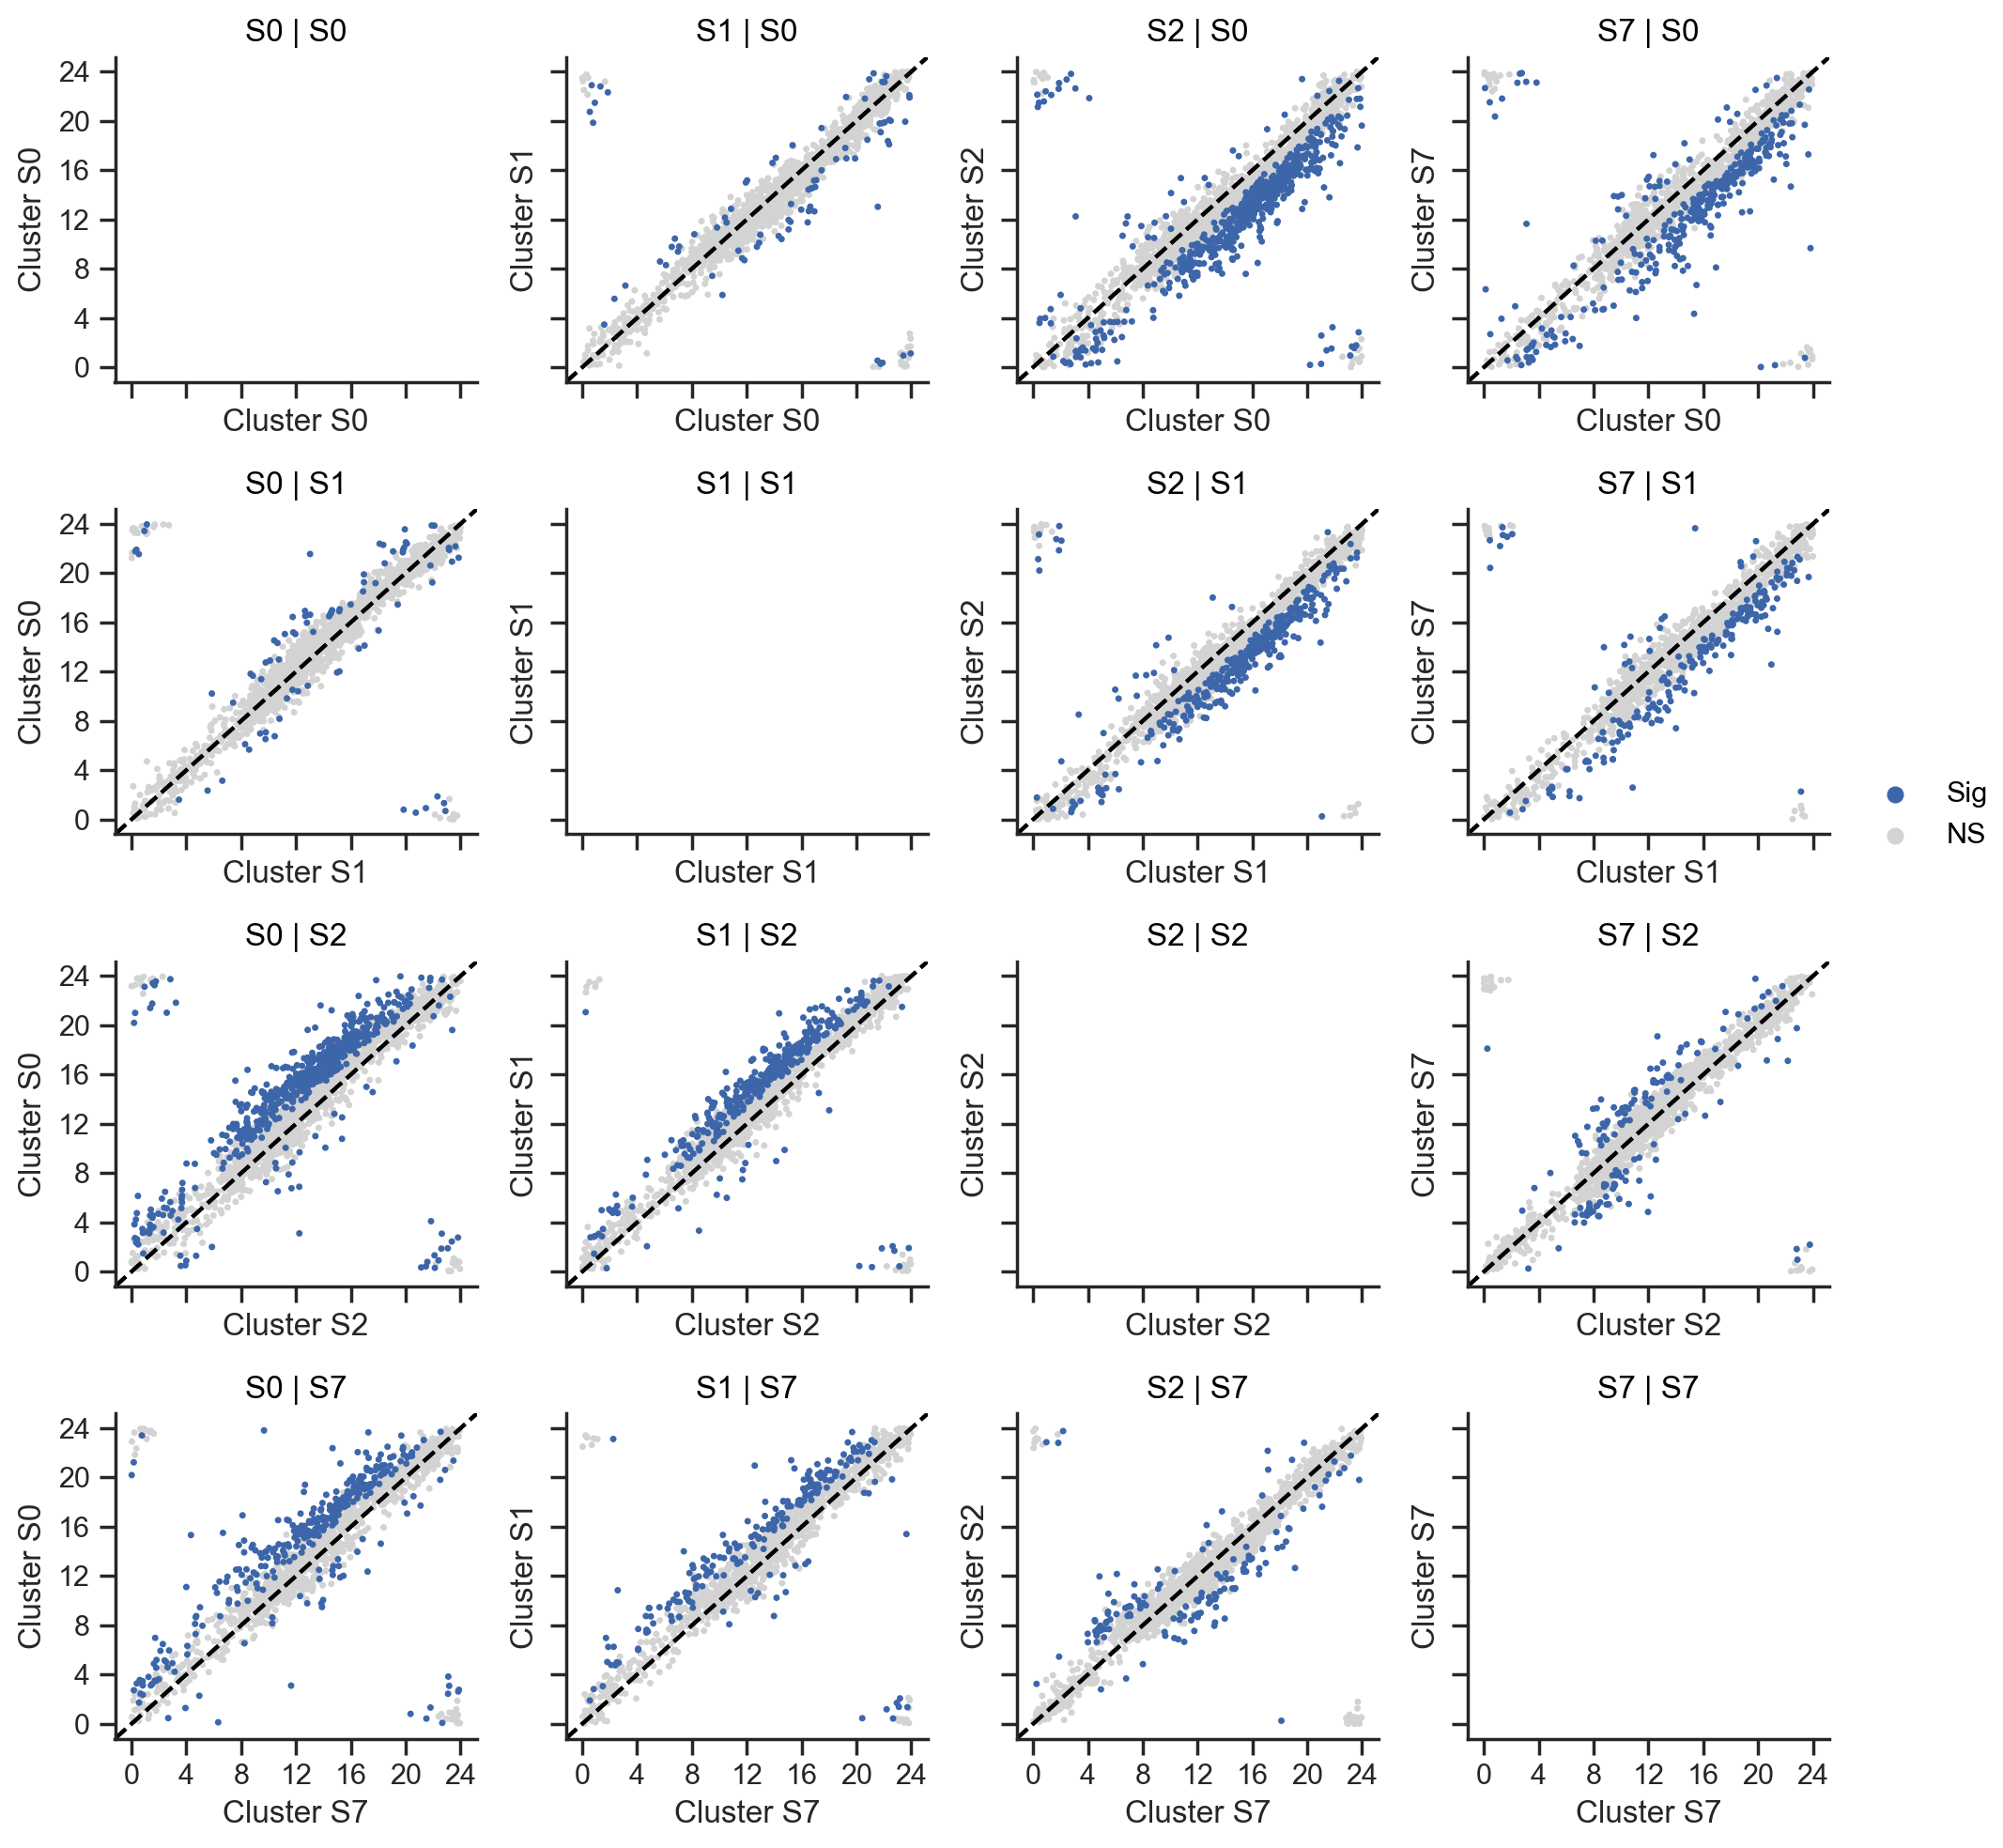

In [ ]:
p, fig = plotDiffPhaseGenes(df_filter,['S0', 'S1', 'S2', 'S7',], ['S0', 'S1', 'S2', 'S7',], figsize=(10, 10))
fig

In [ ]:
fig.savefig('../02_Figures/04_48h_ComparePhase.pdf',dpi = 300)

meta NOT subset; don't know how to subset; dropped
